In [4]:
import numpy as np
from ATI import AboveThresholdIonization

In [5]:
settings_dict = {
    'Ip': 0.5,              # Ionization potential (a.u.)
    'Wavelength': 800,      # (nm)
    'Intensity': 1e14,      # (W/cm^2)
    'cep': np.pi/2,         # Carrier envelope phase
    'N_cycles': 2,          # Nr of cycles
    'build_in_field': 'sin2',   # Build in field type to use. If using other field methods leave as a empty string ''.
    'px_start': -1.5, 'px_end': 1.5,  # Momentum bounds in x direction (a.u.)
    'py_start': 0., 'py_end': 1.5,    # Momentum bounds in y direction (a.u.)
    'pz': 0.,               # Momentum in z direction (a.u.)
    'Nx': 200, 'Ny': 100,   # Grid resolution in the x and y direction
    'N_cores': 4,           # Nr. of cores to use in the multiprocessing calculations
}

Shit does not work - one cannot interract with this garbage

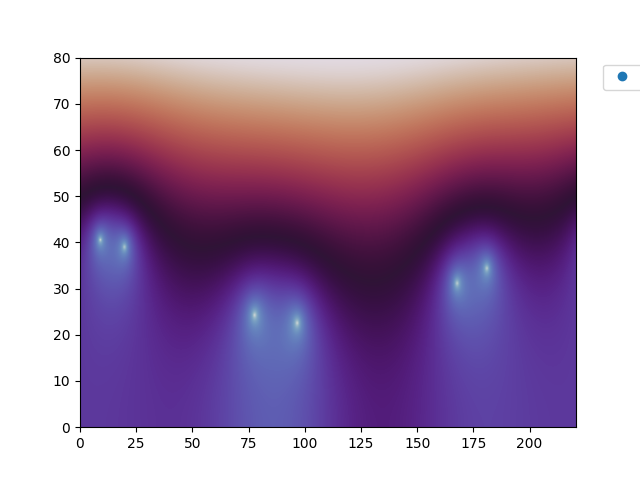

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

In [8]:
ATI = AboveThresholdIonization(settings_dict=settings_dict)
ATI.get_saddle_guess([0, ATI.N_cycles * 2*np.pi/ATI.omega], [0, 80], 400, 400)